# ELT workshop

## Build a simple Prefect flow

### Theory

Here we're building the simplest possible

### Practice

In [1]:
from prefect import Flow, task

@task
def echo(text):
    return text

with Flow("Hello, world - local") as flow:
    hello_world = echo("Hello, world!")

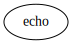

In [2]:
flow.visualize()

In [3]:
state = flow.run()

[2022-01-09 23:08:24+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My first Prefect flow'
[2022-01-09 23:08:24+0000] INFO - prefect.TaskRunner | Task 'echo': Starting task run...
[2022-01-09 23:08:25+0000] INFO - prefect.TaskRunner | Task 'echo': Finished task run for task with final state: 'Success'
[2022-01-09 23:08:25+0000] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


Check the result:

In [4]:
task_ref = flow.get_tasks()[0]
state.result[task_ref]._result

<Result: 'Hello, world!'>

### Check your understanding
- what is a flow?
- what is a task?
- would using Prefect be a good idea if you only had 5 daily scripts to run?
- can you come up with a use case where you could use Prefect (personal or work)?

## Run it from the cloud

Add storage:

In [5]:
from prefect import Flow, task
from prefect.storage import GitHub


@task
def echo(text):
    return text


STORAGE = GitHub(
    repo="dyvenia/elt_workshop",
    path="elt_workshop/prefect/hello_world_sbx.py"
)


with Flow("Hello, world - sandbox", storage=STORAGE) as flow:
    hello_world = echo("Hello, world!")

The flow runs just the same (it doens't pull the repo when ran locally):

In [5]:
state = flow.run()

[2022-01-09 21:49:50+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My first Prefect flow'
[2022-01-09 21:49:50+0000] INFO - prefect.TaskRunner | Task 'echo': Starting task run...
[2022-01-09 21:49:50+0000] INFO - prefect.TaskRunner | Task 'echo': Finished task run for task with final state: 'Success'
[2022-01-09 21:49:50+0000] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


Register the flow in Prefect Cloud:

First, create a project where the flow will live:

In [7]:
!prefect create project "elt_workshop"

elt_workshop created


Now we can send the flow's metadata to Prefect Cloud:

In [6]:
flow.register(project_name="elt_workshop")

Flow URL: https://cloud.prefect.io/trymzet/flow/ae7e2d8f-9bcf-4a84-80f4-de0e52fc300a
 └── ID: d639349a-f31b-4c30-82c0-66c72757b959
 └── Project: elt_workshop
 └── Labels: []


'd639349a-f31b-4c30-82c0-66c72757b959'

<div class="alert alert-block alert-info">
Use Chrome etc. to open the above link as Prefect UI doesn't look well in Firefox
</div>

### Check your understanding
- why do we need to specify the flow's storage when running it from the cloud?
- where are flows triggered by Prefect Cloud running?

## Build a production-grade simple Prefect flow

When deploying to production, we want to add several components:

1. Specify a reproducible environment in which the flow will be executed  
Because reproducibility is very important. 

By default, Docker Agent uses the `prefecthq/prefect:latest` image.

2. Add alerts in case our flow failure  
Allows us to take immediate action.

3. Add scheduling  
We usually want to automate repeatable tasks

For point no. 2, we will need to do a bit of set up and config work:
> These instructions are intentionally left high-level -- you're welcome to create a PR that changes these vague instructions into recipes for extra points!
1. [Set up a Slack workspace](https://slack.com/help/articles/206845317-Create-a-Slack-workspace)
2. Follow [this](https://prefect-slack.appspot.com/) link to connect Prefect notifications to a Slack channel.
3. Add the webhook url to your Prefect Cloud secrets with the name `SLACK_WEBHOOK_URL`

In [ ]:
from prefect.storage import GitHub
from prefect.run_configs.docker import DockerRun
from prefect.utilities.notifications import slack_notifier
from prefect.schedules import Schedule
from prefect.schedules.clocks import CronClock
from prefect.engine.state import Failed
from prefect import Flow, task


STORAGE = GitHub(
    repo="dyvenia/elt_workshop",
    path="elt_workshop/prefect/hello_world_dev.py"
)
RUN_CONFIG = DockerRun(
    image="prefecthq/prefect:0.15.11-python3.9",
    env={"HTTP_PROXY": "SOME_IP_ADDR"},
    labels=["dev"],
)
SLACK_NOTIFIER = slack_notifier(only_states=[Failed])
SCHEDULE = Schedule(clocks=[CronClock("* */12 * * *")])

@task
def echo(text):
    return text

with Flow(
    "Hello, world - dev",
    storage=STORAGE,
    run_config=RUN_CONFIG,
    state_handlers=[SLACK_NOTIFIER],
    schedule=SCHEDULE,
) as flow:
    hello_world = echo("Hello, world!")

In [11]:
!prefect create project "dev"

dev created


In [12]:
flow.register(project_name="dev")

Flow URL: https://cloud.prefect.io/trymzet/flow/2992babe-8539-478c-be0e-8a5456f5b70a
 └── ID: 937a45de-a108-485b-ad55-b96cf4b08bb0
 └── Project: dev
 └── Labels: ['dev']


'937a45de-a108-485b-ad55-b96cf4b08bb0'

<div class="alert alert-block alert-warning">
    If you click the link and go to the flow now, you will see an alert next to "labels". <br/><br/>
    This is because the agent we've been using so far does not have the "dev" label. In order to fix this, we need to start another agent with a "dev" label. Run `start_prefect_agent_dev.sh` to do that.
</div>

### Understanding
- why is pinning the version of the Docker image important? What could happen if we don't pin it and simply use `latest`?

## Build a Prefect flow to run an Airbyte sync

## `AirbyteConnectionTask2` 
This is needed until the PR to Prefect is accepted. I cleaned up the messy logs from the original Prefect task and added some improvements.

In [11]:
from time import sleep
import uuid

import requests
from requests import RequestException

from prefect import Task
from prefect.engine.signals import FAIL
from prefect.utilities.tasks import defaults_from_attrs
import logging
import re
from typing import List, Tuple


class ConnectionNotFoundException(Exception):
    pass


class AirbyteServerNotHealthyException(Exception):
    pass


class JobNotFoundException(Exception):
    pass


class AirbyteConnectionTask2(Task):
    """
    Task for triggering Airbyte Connections, where "A connection is
    a configuration for syncing data between a source and a destination."
    For more information refer to the
    [Airbyte docs](https://docs.airbyte.io/understanding-airbyte/connections)
    This task assumes that the Airbyte Open-Source, since "For
    Airbyte Open-Source you don't need the API Token for
    Authentication! All endpoints are possible to access using the
    API without it."
    For more information refer to the [Airbyte docs](https://docs.airbyte.io/api-documentation)
    Args:
        - airbyte_server_host (str, optional): Hostname of Airbyte server where connection is configured.
            Defaults to localhost.
        - airbyte_server_port (str, optional): Port that the Airbyte server is listening on.
            Defaults to 8000.
        - airbyte_api_version (str, optional): Version of Airbyte API to use to trigger connection sync.
            Defaults to v1.
        - connection_id (str, optional): Default connection id to
            use for sync jobs, if none is specified to `run`.
        - **kwargs (Any, optional): additional kwargs to pass to the
            base Task constructor
    """

    # Connection statuses
    CONNECTION_STATUS_ACTIVE = "active"
    CONNECTION_STATUS_INACTIVE = "inactive"
    CONNECTION_STATUS_DEPRECATED = "deprecated"

    # Job statuses
    # pending┃running┃incomplete┃failed┃succeeded┃cancelled
    JOB_STATUS_SUCCEEDED = "succeeded"
    JOB_STATUS_FAILED = "failed"
    JOB_STATUS_PENDING = "pending"
    
    # Attempt statuses
    ATTEMPT_STATUS_SUCCEEDED = "succeeded"
    ATTEMPT_STATUS_FAILED = "failed"
    ATTEMPT_STATUS_RUNNING = "running"
    

    def __init__(
        self,
        airbyte_server_host: str = "localhost",
        airbyte_server_port: int = 8000,
        airbyte_api_version: str = "v1",
        connection_id: str = None,
        **kwargs,
    ):
        self.airbyte_server_host = airbyte_server_host
        self.airbyte_server_port = airbyte_server_port
        self.airbyte_api_version = airbyte_api_version
        self.connection_id = connection_id
        super().__init__(**kwargs)

    def _check_health_status(self, session: requests.Session) -> bool:
        get_connection_url = self.airbyte_base_url + "/health/"
        try:
            response = session.get(get_connection_url)
            health_status = response.json()["db"]
            if not health_status:
                raise AirbyteServerNotHealthyException(
                    f"Airbyte Server health status: {health_status}"
                )
            return True
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)
            
    def _get_connection_source_and_dest(self, session: requests.Session) -> Tuple[str, str]:
        """Get source and destination names for the connection ID.
        Note `web_backend` in the URL"""
        get_connection_url = self.airbyte_base_url + "/web_backend/connections/get/"
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )
            source = response.json()["source"]["name"]
            destination = response.json()["destination"]["name"]
            return source, destination
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    def _get_connection_status(self, session: requests.Session) -> str:
        get_connection_url = self.airbyte_base_url + "/connections/get/"
        
        # TODO - Missing authentication because Airbyte servers currently do not support authentication
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )

            # check whether a schedule exists ...
            schedule = response.json()["schedule"]
            if schedule:
                self.logger.warning("Found existing Connection schedule, removing ...")

                # mandatory fields for Connection update ...
                sync_catalog = response.json()["syncCatalog"]
                connection_status = response.json()["status"]

                update_connection_url = self.airbyte_base_url + "/connections" "/update/"
                response2 = session.post(
                    update_connection_url,
                    json={
                        "connectionId": self.connection_id,
                        "syncCatalog": sync_catalog,
                        "schedule": None,
                        "status": connection_status,
                    },
                )

                if response2.status_code == 200:
                    self.logger.info("Schedule removed.")
                else:
                    self.logger.warning("Schedule not removed.")
                    self.logger.warning(response2.json())

            connection_status = response.json()["status"]
            return connection_status
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    def _trigger_manual_sync_connection(self, session: requests.Session) -> Tuple[int, int]:
        """
        Trigger a manual sync of the Connection, see:
        https://airbyte-public-api-docs.s3.us-east-2.amazonaws.com/rapidoc
        -api-docs.html#post-/v1/connections/sync
        Args:
            session: requests session with which to make call to Airbyte server
        Returns: job_id, job_created_at - timestamp of sync job creation
        """
        get_connection_url = self.airbyte_base_url + "/connections/sync/"

        # TODO - missing authentication ...
        try:
            response = session.post(
                get_connection_url, json={"connectionId": self.connection_id}
            )
            if response.status_code == 200:
                job_id = response.json()["job"]["id"]
                job_created_at = response.json()["job"]["createdAt"]
                return job_id, job_created_at
            elif response.status_code == 404:
                raise ConnectionNotFoundException(
                    f"Connection {connection_id} not found, please double "
                    f"check the connection_id ..."
                )
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)
    
    @staticmethod
    def _escape_ansi(line: str) -> str:
        ansi_escape = re.compile(r'(?:\x1B[@-_]|[\x80-\x9F])[0-?]*[ -/]*[@-~]')
        return ansi_escape.sub('', line)
    
    def _get_stripped_logger(self):
        """Helper method for _log_airbyte_logs()"""
        root_logger = logging.getLogger("prefect")
        
        handler = [h for h in root_logger.handlers if type(h) == logging.StreamHandler][0]
        prev_formatter = handler.formatter
        formatter = logging.Formatter(fmt='%(message)s')
        handler.setFormatter(formatter)
        
        stripped_logger = root_logger.getChild(self.name)
        
        return stripped_logger, prev_formatter
    
    def _recover_prefect_logger(self, prev_formatter: logging.Formatter) -> None:
        """Helper method for _log_airbyte_logs()"""
        root_logger = logging.getLogger("prefect")
        
        handler = [h for h in root_logger.handlers if type(h) == logging.StreamHandler][0]
        handler.setFormatter(prev_formatter)
    
    def _log_airbyte_logs(self, logs: List[str]) -> None:
        """Take a list of Airbyte logs and log them with the Prefect logger"""
        logger, prev_formatter = self._get_stripped_logger()
        for log in logs:
            log_escaped = self._escape_ansi(log)
            logger.debug(log_escaped)
        self._recover_prefect_logger(prev_formatter)

    def _get_job_status(
        self, session: requests.Session, job_id: int
    ) -> Tuple[str, int, int]:
        get_connection_url = self.airbyte_base_url + "/jobs/get/"
        try:
            response = session.post(get_connection_url, json={"id": job_id})
            if response.status_code == 200:
                job_status = response.json()["job"]["status"]
                
                if job_status == self.JOB_STATUS_SUCCEEDED:
                    attempts = response.json()["attempts"]
                    successful_attempt = [
                        a for a in attempts if a["attempt"]["status"] == self.ATTEMPT_STATUS_SUCCEEDED
                    ][0]

                    self._log_airbyte_logs(successful_attempt["logs"]["logLines"])
                                     
                job_created_at = response.json()["job"]["createdAt"]
                job_updated_at = response.json()["job"]["updatedAt"]
                return job_status, job_created_at, job_updated_at
            elif response.status_code == 404:
                self.logger.error(f"Job {job_id} not found...")
                raise JobNotFoundException(f"Job {job_id} not found...")
        except RequestException as e:
            raise AirbyteServerNotHealthyException(e)

    @defaults_from_attrs(
        "airbyte_server_host",
        "airbyte_server_port",
        "airbyte_api_version",
        "connection_id",
    )
    def run(
        self,
        airbyte_server_host: str = None,
        airbyte_server_port: int = None,
        airbyte_api_version: str = None,
        connection_id: str = None,
        display_airbyte_logs: bool = None,
        poll_interval_s: int = 15,
    ) -> dict:
        """
        Task run method for triggering an Airbyte Connection.
        *It is assumed that the user will have previously configured
        a Source & Destination into a Connection.*
        e.g. MySql -> CSV
        An invocation of `run` will attempt to start a sync job for
        the specified `connection_id` representing the Connection in
        Airbyte.
        `run` will poll Airbyte Server for the Connection status and
        will only complete when the sync has completed or
        when it receives an error status code from an API call.
        Args:
            - airbyte_server_host (str, optional): Hostname of Airbyte server where connection is
                configured. Will overwrite the value provided at init if provided.
            - airbyte_server_port (str, optional): Port that the Airbyte server is listening on.
                Will overwrite the value provided at init if provided.
            - airbyte_api_version (str, optional): Version of Airbyte API to use to trigger connection
                sync. Will overwrite the value provided at init if provided.
            - connection_id (str, optional): if provided,
                will overwrite the value provided at init.
            - poll_interval_s (int, optional): this task polls the
                Airbyte API for status, if provided this value will
                override the default polling time of 15 seconds.
        Returns:
            - dict: connection_id (str) and succeeded_at (timestamp str)
        """
        
        if not connection_id:
            raise ValueError("`connection_id` *must* be provided.")

        try:
            uuid.UUID(connection_id)
        except (TypeError, ValueError):
            raise ValueError(
                "Parameter `connection_id` *must* be a valid UUID \
                i.e. 32 hex characters, including hyphens."
            )
            
        self.connection_id = connection_id

        # see https://airbyte-public-api-docs.s3.us-east-2.amazonaws.com
        # /rapidoc-api-docs.html#overview
        self.airbyte_base_url = (
            f"http://{airbyte_server_host}:"
            f"{airbyte_server_port}/api/{airbyte_api_version}"
        )

        session = requests.Session()
        self._check_health_status(session)

        connection_status = self._get_connection_status(session)
        if connection_status == self.CONNECTION_STATUS_ACTIVE:
            # Trigger manual sync on the Connection ...
            source, destination = self._get_connection_source_and_dest(session)
            self.logger.info(f"Triggering Airbyte sync '{source}' -> '{destination}'...")
                
            job_id, job_created_at = self._trigger_manual_sync_connection(session)

            job_status = self.JOB_STATUS_PENDING

            while job_status not in [self.JOB_STATUS_FAILED, self.JOB_STATUS_SUCCEEDED]:
                job_status, job_created_at, job_updated_at = self._get_job_status(
                    session, job_id
                )

                if job_status == self.JOB_STATUS_SUCCEEDED:
                    self.logger.info(f"Job {job_id} succeeded.")
                elif job_status == self.JOB_STATUS_FAILED:
                    self.logger.error(f"Job {job_id} failed.")
                else:
                    # wait for next poll interval
                    sleep(poll_interval_s)

            return {
                "connection_id": connection_id,
                "status": connection_status,
                "job_status": job_status,
                "job_created_at": job_created_at,
                "job_updated_at": job_updated_at,
            }
        elif connection_status == self.CONNECTION_STATUS_INACTIVE:
            self.logger.error(
                f"Please enable the Connection {connection_id} in Airbyte Server."
            )
            raise FAIL(
                f"Please enable the Connection {connection_id} in Airbyte Server."
            )
        elif connection_status == self.CONNECTION_STATUS_DEPRECATED:
            self.logger.error(f"Connection {connection_id} is deprecated.")
            raise FAIL(f"Connection {connection_id} is deprecated.")

In [10]:
from datetime import timedelta

from prefect import Flow, Parameter, task
from prefect.run_configs.docker import DockerRun
from prefect.storage.local import Local
from prefect.tasks.airbyte.airbyte import AirbyteConnectionTask
from prefect.tasks.dbt.dbt import DbtShellTask

RUN_CONFIG = DockerRun(
    image="viadot:latest",
    env={"SOME_VAR": "value"},
    labels=["dev"],
)

sync_airbyte_connection = AirbyteConnectionTask2(
    max_retries=3,
    retry_delay=timedelta(seconds=10),
    airbyte_server_host="webapp",
    airbyte_server_port=80,
    airbyte_api_version="v1"
)


with Flow("Sync pokeAPI to Metabase - local", storage=Local(), run_config=RUN_CONFIG) as flow:
    # Airbyte connection strings
    airbyte_poke_connection_id = Parameter("AIRBYTE_POKE_CONNECTION_ID")

    # Sync
    sync_poke = sync_airbyte_connection(connection_id=airbyte_poke_connection_id)

    
# flow.visualize()
flow.run(AIRBYTE_POKE_CONNECTION_ID="4a6d8e08-936a-4820-bfb6-3c676866adc4")

Beginning Flow run for 'Determine common contributors flow'
Task 'AIRBYTE_POKE_CONNECTION_ID': Starting task run...
Task 'AIRBYTE_POKE_CONNECTION_ID': Finished task run for task with final state: 'Success'
Task 'AirbyteConnectionTask2': Starting task run...
Triggering Airbyte sync 'workshop_poke' -> 'workshop_local_json'...
2021-12-24 15:19:14 INFO i.a.s.a.w.WorkerRun(call):49 - Executing worker wrapper. Airbyte version: 0.34.2-alpha
2021-12-24 15:19:14 INFO i.a.w.t.TemporalAttemptExecution(get):118 - Docker volume job log path: /tmp/workspace/54/0/logs.log
2021-12-24 15:19:14 INFO i.a.w.t.TemporalAttemptExecution(get):123 - Executing worker wrapper. Airbyte version: 0.34.2-alpha
2021-12-24 15:19:14 WARN i.a.d.Databases(createPostgresDatabaseWithRetryTimeout):65 - Waiting for database to become available...
2021-12-24 15:19:14 INFO i.a.d.i.j.JobsDatabaseInstance(lambda$static$2):25 - Testing if jobs database is ready...
2021-12-24 15:19:14 INFO i.a.d.Databases(createPostgresDatabaseWit

<Success: "All reference tasks succeeded.">

Run below in a terminal before and after the sync to see if the file was actually reloaded:  
`cat /tmp/airbyte_local/workshop/poke/_airbyte_raw_pokemon.jsonl | python -m json.tool | grep _airbyte_emitted_at`

## Build the full Prefect flow

In [ ]:
from datetime import timedelta

from prefect import Flow, Parameter, task
from prefect.run_configs.docker import DockerRun
from prefect.storage.local import Local
from prefect.tasks.airbyte.airbyte import AirbyteConnectionTask
from prefect.tasks.dbt.dbt import DbtShellTask


...